# In this notebook, I have implemented power law analysis methods on empirical data from the following paper: https://arxiv.org/pdf/0706.1062.

For a discrete distribution that follows a power law behavior above a value $x_{min}>0$, the probability at an observed value x is given as $$p(x) = \frac{x^{-\alpha}}{\zeta(\alpha, x_{min})}\tag{1}$$ where $$\zeta(\alpha, x_{min})=\sum_{n=0}^\infty (n+x_{min})^{-\alpha}\tag{2}$$ is the generalized or Hurwitz zeta function. For the case when $x_{min}=1$, the exponent $\alpha$ that maximizes the likelihood is the solution to the transcendental equation $$\frac{\zeta'(\hat{\alpha})}{\zeta(\hat{\alpha})}=-\frac{1}{n}\sum_{i=1}^n\ln{x_i}\tag{3}$$. Note that the zeta functions above are Riemann zeta function. When $x_{min}>1$, the MLE for $\alpha$ is given by following equation: $$\frac{\zeta'(\hat{\alpha}, x_{min})}{\zeta(\hat{\alpha}, x_{min})} = -\frac{1}{n} \sum_{i=1}^n\ln{x_i}\tag{4}$$ where the prime denotes differentiation with respect to $\alpha$. 
Alternatively, one can estimate α by direct numerical maximization of the likelihood function itself, or equivalently of its logarithm (which is usually simpler): $$\ln\mathcal{L}(\alpha)=-n\ln{\zeta(\alpha, x_{min})}-\alpha\sum_{i=1}^n\ln{x_i}\tag{5}$$.
The MLE $\hat{\alpha}$ can be found close to $$\hat{\alpha} \approx 1+n\left[\sum_{i=1}^{n}\ln{\frac{x_i}{x_{min}-\frac{1}{2}}}\right]^{-1}\tag{6}$$.
The standard error on $\hat{\alpha}$ is given by $$\sigma = 1/\sqrt{n\left[\frac{\zeta''(\hat{\alpha}, x_{min})}{\zeta(\hat{\alpha}, x_{min})} - \left(\frac{\zeta'(\hat{\alpha}, x_{min})}{\zeta(\hat{\alpha}, x_{min})}\right)^2\right]}\tag{7}$$.
Zeta functions and their derivatives are readily availbale in mpmath python. Lets import them and implement them.

In [1]:
import numpy as np
import mpmath as mp
#### SANITY CHECK ####
print(f'PYTHON ZETA(1/2)={np.float32(mp.zeta(0.5, derivative=0))}, ANALYTICAL ZETA(2)={-1.46035450880958681288}')
print(f'PYTHON ZETA(-1)={np.float32(mp.zeta(-1, derivative=0))}, ANALYTICAL ZETA(-1)={-1/12}')
print(f'PYTHON ZETA(2)={np.float32(mp.zeta(2, derivative=0))}, ANALYTICAL ZETA(-1)={np.pi*np.pi/6}')

ModuleNotFoundError: No module named 'mpmath'

In [2]:
from scipy.optimize import fsolve, minimize, curve_fit

In [3]:
def power_law_pdf(alpha, x, xmin):
    # Convert input x to a numpy array of floats and flatten it for processing
    x = np.array(x, dtype=float).flatten()
    zeta = np.float32(mp.zeta(alpha, xmin, derivative=0))
    value = x**(-alpha) / zeta
    return value

In [4]:
def transcendental(alpha, x, xmin): #These are equation 3 and 4 implemented here.
    # Ensure alpha is a scalar
    alpha = alpha.item()  # Extract single element from the array
    zeta = np.float32(mp.zeta(alpha, xmin, derivative=0))
    zeta_prime = np.float32(mp.zeta(alpha, xmin, derivative=1))
    lhs = zeta_prime/zeta
    rhs = -np.mean(np.log(x))
    equation = lhs-rhs
    return equation

In [5]:
def initial_alpha(x, xmin): # Approximate MLE alpha given by equation 6.
    # Convert input x to a numpy array of floats and flatten it for processing
    x = np.array(x, dtype=float).flatten()
    n = len(x)
    value =  1. + n * (1./sum(np.log(x/(xmin-0.5))))
    return value 

In [6]:
def solve_for_alpha(x, xmin): # solving transcendental equation for optimal alpha
    alpha0 = initial_alpha(x, xmin)
    alpha_solution = fsolve(transcendental, alpha0, args=(x, xmin))
    return alpha_solution[0]

In [7]:
def nll(alpha, x, xmin):
    # Ensure alpha is a scalar
    alpha = alpha.item()  # Extract single element from the array
    n = len(x)
    zeta = np.float32(mp.zeta(alpha, xmin, derivative=0))
    try:
        ll = -n * np.log(zeta) - alpha * np.sum(np.log(x))
        # ll = -n * np.log(C) - alpha * np.sum(np.log(x))
    except ValueError:
        return np.inf  # Return a large number if log operation fails
    return -ll

def nll2(alpha, x):
    n = len(x)
    penalty = 1e10 if np.isclose(alpha, 1) else 0  # Large penalty if alpha is close to 1
    try:
        ll = -n * np.log(np.sum(x**(-alpha))) - alpha * np.sum(np.log(x))
    except ValueError:
        return np.inf  # Return a large number if log operation fails
    return -ll + penalty


In [8]:
def std_err(alpha, x, xmin):
    n = len(x)
    zeta = np.float32(mp.zeta(alpha, xmin, derivative=0))
    zeta_prime = np.float32(mp.zeta(alpha, xmin, derivative=1))
    zeta_prime_prime = np.float32(mp.zeta(alpha, xmin, derivative=2))
    first = zeta_prime_prime/zeta
    second = (zeta_prime/zeta)**2
    inside_root = n*(first-second)
    return 1./np.sqrt(inside_root)

In [9]:
# Example data
x_data = np.array(range(1, 100001))  # Replace with your actual data
xmin = 10
# Initial guess for alpha
alpha0 = initial_alpha(x_data, xmin)

optimal_alpha = solve_for_alpha(x_data, xmin)
se = std_err(optimal_alpha, x_data, xmin)
print(r'$\alpha$ '+ rf'from solving: {optimal_alpha:.2f}$\pm{se:.2f}$')
# Minimize the negative log likelihood
result = minimize(nll, alpha0, args=(x_data, xmin), bounds=[(0, 10),])

# Optimal alpha
optimal_alpha = result.x[0]
print(r'$\alpha$ '+ f'from likelihood: {optimal_alpha}')

###################################################################
result2 = minimize(nll2, alpha0, args=(x_data,), bounds=[(1, 10),])
# Optimal alpha
optimal_alpha2 = result2.x[0]
print(r'$\alpha$ '+ f'from likelihood2: {optimal_alpha2}')
###################################################################

$\alpha$ from solving: 1.12$\pm0.00$


/tmp/ipykernel_2964209/719572569.py:7: RuntimeWarning: invalid value encountered in log
  ll = -n * np.log(zeta) - alpha * np.sum(np.log(x))


$\alpha$ from likelihood: 1.1210708598525572
$\alpha$ from likelihood2: 1.000010075280865


# Now lets extract exponents $\alpha$ for our data.

In [4]:
import sys, os, glob
root_dir = '/home/gddaslab/mxp140/tcr_project_ultimate'
sys.path.append(root_dir)

In [5]:
import json
import pandas as pd
from pdf import pdf
from ccf import ccf
import tqdm as tqdm
import matplotlib.pyplot as plt

In [6]:
with open(f'{root_dir}/data/patient_info.json', 'r') as f:
    patient_info = json.load(f)
patients = list(patient_info['BrMET'].keys()) + list(patient_info['GBM'].keys())
full_data = pd.read_csv(f"{root_dir}/data/BrMET_and_GBM_data.csv", sep=",")

results = []  # Initialize a list to store results for each patient
for patient_id in patients[:]:
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(10, 5),
    )
    patient_data = full_data[full_data["Patient"]==patient_id]
    data = pdf(patient_data["counts"].values)
    x_data, y_data = data[0], data[1]
    ax.scatter(x_data, y_data, s=100, facecolors="white", edgecolors="black", label="data", zorder=1, alpha=1)
    
    xmin = 3
    # xmax_dict = {'BrMET008':17, 'BrMET009':60, 'BrMET010':10, 'BrMET018':200, 'BrMET019':50, 'BrMET025':50, 'BrMET027':70, 'BrMET028':10, 'GBM032':70, 'GBM052':100, 'GBM055':100, 'GBM056':60, 'GBM059':80, 'GBM062':8, 'GBM063':20, 'GBM064':8, 'GBM070':30, 'GBM074':20, 'GBM079':20,} 
    # xmax = xmax_dict.get(patient_id, 100)
    # fit_patient_data = patient_data[(patient_data['counts']>=xmin) & (patient_data['counts']<=xmax)]
    # fit_data = pdf(fit_patient_data["counts"].values)
    # fit_x_data, fit_y_data = fit_data[0], fit_data[1]
    # best_alpha = solve_for_alpha(fit_x_data, xmin)
    # se_alpha = std_err(best_alpha, fit_x_data, xmin)
    # ax.scatter(fit_x_data, fit_y_data, s=100, facecolors="green", edgecolors="black", label="data for fit", zorder=1, alpha=1)
    # ax.plot(fit_x_data, power_law_pdf(best_alpha, fit_x_data, xmin), linewidth=1.5, color='green', label=r'best $\mathcal{L}$ model')
    
    # Find the index of the first occurrence of min(y_data)
    min_index = np.argmin(y_data)
    xmax_start = x_data[min_index]
    best_xmax = None
    best_fit_x_data = None
    best_fit_y_data = None
    min_noise = np.inf
    best_alpha = None
    for xmax in tqdm.tqdm(range(xmax_start, max(x_data)+1), leave=False):
        fit_patient_data = patient_data[(patient_data['counts']>=xmin) & (patient_data['counts']<=xmax)]
        fit_data = pdf(fit_patient_data["counts"].values)
        fit_x_data, fit_y_data = fit_data[0], fit_data[1]
        optimal_alpha = solve_for_alpha(fit_x_data, xmin)
        y_pred = power_law_pdf(optimal_alpha, fit_x_data, xmin)
        avgRSS =  (np.sum((np.log(y_pred) - np.log(fit_y_data)) ** 2)) / len(fit_x_data)
        if avgRSS < min_noise:
            min_noise = avgRSS
            best_xmax = xmax
            best_fit_x_data = fit_x_data
            best_fit_y_data = fit_y_data
            best_alpha = optimal_alpha
            
    ax.scatter(best_fit_x_data, best_fit_y_data, s=100, facecolors="green", edgecolors="black", label="data for fit", zorder=1, alpha=1)
    ax.plot(best_fit_x_data, power_law_pdf(best_alpha, best_fit_x_data, xmin), linewidth=1.5, color='green', label=r'best $\mathcal{L}$ model')
    
    se_alpha = std_err(best_alpha, best_fit_x_data, xmin)
    # # Append results for the current patient
    results.append({
        "Patient": patient_id,
        "alpha": best_alpha,
        "sigma":se_alpha,
        "xmin":xmin,
        "xmax": best_xmax,
        "XMAX": max(x_data),
        "n":len(best_fit_x_data),
        "N":len(x_data)
    })
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    # ax.vlines(x=best_xmax, ymin=min(ax.get_yticks()), ymax=max(ax.get_yticks()), linestyles="dashed", colors="gray")
    # ax.text(1.2*best_xmax, np.log10((max(ax.get_yticks())+min(ax.get_yticks()))/2), f'x={best_xmax}', horizontalalignment='center', fontsize=12, color='black')
    ax.set_xlabel(r"Clone Sizes ($x$)", fontsize=24)
    ax.set_ylabel("PDF", fontsize=24)
    ax.legend(loc="best", fontsize=20)
    ax.set_title(f"{patient_id}", fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.show()

In [16]:
result_df = pd.DataFrame(results)
result_df

,Patient,alpha,sigma,xmin,xmax,XMAX,n,N
0,BrMET008,1.810382,0.217452,3,17,133,14,21
1,BrMET009,1.487579,0.075346,3,44,6314,42,163
2,BrMET010,1.715728,0.169229,3,20,837,18,58
3,BrMET018,1.615733,0.123435,3,27,696,25,83
4,BrMET019,1.796971,0.206576,3,17,358,15,53
5,BrMET025,1.987054,0.313975,3,12,384,10,35
6,BrMET027,1.497554,0.078791,3,45,476,40,79
7,BrMET028,1.933800,0.283042,3,13,32,11,18
8,GBM032,1.584282,0.110652,3,30,191,28,72
9,GBM052,1.564675,0.103298,3,34,1178,30,69


result_df.to_csv("results/exponents.csv", sep=',', index=False)

# Statistical tests for exponents from two group of patients

In [17]:
exponents_df = pd.read_csv('results/exponents.csv', sep=',')
exponents_df

,Patient,alpha,sigma,xmin,xmax,XMAX,n,N
0,BrMET008,1.810382,0.217452,3,17,133,14,21
1,BrMET009,1.487579,0.075346,3,44,6314,42,163
2,BrMET010,1.715728,0.169229,3,20,837,18,58
3,BrMET018,1.615733,0.123435,3,27,696,25,83
4,BrMET019,1.796971,0.206576,3,17,358,15,53
5,BrMET025,1.987054,0.313975,3,12,384,10,35
6,BrMET027,1.497554,0.078791,3,45,476,40,79
7,BrMET028,1.933800,0.283042,3,13,32,11,18
8,GBM032,1.584282,0.110652,3,30,191,28,72
9,GBM052,1.564675,0.103298,3,34,1178,30,69


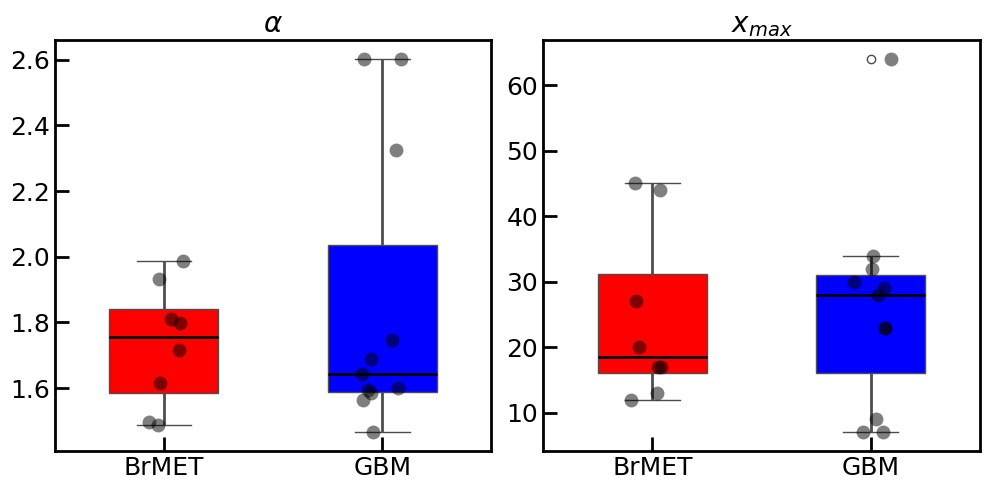

In [25]:
import seaborn as sns
exponents_df["GBM"] = exponents_df["Patient"].str.contains("GBM")
columns = ["alpha", "xmax"]
titles = [rf'$\alpha$', r'$x_{max}$']
colors = {False: 'red', True: 'blue'}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for i, (ax, col) in enumerate(zip(axes, columns)):
    sns.boxplot(
        x="GBM",
        y=col,
        data=exponents_df,
        hue="GBM",
        palette=colors,
        saturation=1,
        legend=False,
        width=0.5,
        ax=ax,
        medianprops={"color": "black", "linewidth": 2},
        whiskerprops={"linewidth": 2},
    )
    sns.stripplot(
        x="GBM",
        y=col,
        data=exponents_df,
        color='black',  # Color of the points
        alpha=0.5,      # Transparency of the points
        ax=ax,
        size=10          # Size of the points
    )
    # # Assuming you have a column 'error' in your DataFrame for individual errors
    # for index, row in exponents_df.iterrows():
    #     ax.errorbar(
    #         x=1 if row['GBM'] else 0,  # Use 1 for GBM and 0 for BrMET
    #         y=row[col],
    #         yerr=row['sigma'],  # Replace 'error' with the actual column name for errors
    #         fmt='o',
    #         color='black',
    #         capsize=5,
    #         alpha=0.5
    #     )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["BrMET", "GBM"])
    ax.set_title(titles[i], fontsize=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    xtick_labels, ytick_labels = ax.get_xticklabels(), ax.get_yticklabels()
    for label in xtick_labels + ytick_labels:
        label.set_fontsize(24)
    ax.tick_params(
        axis="x", which="major", direction="in", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="x", which="minor", direction="in", length=5, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="major", direction="in", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="minor", direction="in", length=5, width=2, labelsize=18
    )
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.yaxis.labelpad = 20
    ax.xaxis.labelpad = 20
plt.tight_layout()
plt.show()

In [36]:
from scipy.stats import f, levene, bartlett, ttest_ind

In [37]:
exp_brmet = exponents_df[exponents_df["Patient"].str.contains('BrMET')]['alpha'].values
error_brmet = exponents_df[exponents_df["Patient"].str.contains('BrMET')]['sigma'].values
exp_gbm = exponents_df[exponents_df["Patient"].str.contains('GBM')]['alpha'].values
error_gbm = exponents_df[exponents_df["Patient"].str.contains('GBM')]['sigma'].values

In [43]:
######## TEST OF EQUAL VARIANCEs ########

########## F-TEST #################
group1, group2 = exp_brmet, exp_gbm
group1_error, group2_error = error_brmet, error_gbm
var1 = np.var(exp_brmet, ddof=1)
var2 = np.var(exp_gbm, ddof=1)
# Calculate F-statistic
F = var1 / var2
# Degrees of freedom
n1 = len(group1)
n2 = len(group2)
df1 = n1 - 1
df2 = n2 - 1
# Calculate p-value
p_value = 1 - f.cdf(F, df1, df2)
# Output results
print(f"F-statistic: {F}, p-value: {p_value}")

########## LEVENE'S-TEST #################
stat, p_value = levene(group1, group2)
print(f"Levene's test statistic: {stat}, p-value: {p_value}")

########## BARTLETT's-TEST #################
stat, p_value = bartlett(group1, group2)
print(f"Bartlett's test statistic: {stat}, p-value: {p_value}")



############ STANDARD T-TEST ################
mean1 = np.mean(group1)
mean2 = np.mean(group2)
std1 = np.std(group1, ddof=1)
std2 = np.std(group2, ddof=1)
t_stat, p_value = ttest_ind(group1, group2, equal_var=False)  # Use equal_var=False for Welch's t-test
print(f"Mean of Group 1: {mean1}, Standard Deviation: {std1}")
print(f"Mean of Group 2: {mean2}, Standard Deviation: {std2}")
print(f"Welch's t-statistic: {t_stat}, p-value: {p_value}")

F-statistic: 0.1874174222434974, p-value: 0.9816446343675601
Levene's test statistic: 0.9420268561134767, p-value: 0.3453649429278987
Bartlett's test statistic: 4.518668693488851, p-value: 0.0335269103348864
Mean of Group 1: 1.7306000488853686, Standard Deviation: 0.1869356503345432
Mean of Group 2: 1.8556409798359086, Standard Deviation: 0.431804489161394
Welch's t-statistic: -0.8563928599909814, p-value: 0.40576125818537867


# HOWEVER ALL OF THE ABOVE ANALYSIS IS BASED ON THE FACT THAT THE POWER LAW IS VALID FOR REGION $x_{min}>0$. BUT IN OUR CASE, OUR DATA SEEMS TO HAVE POWER LAW BETWEEN a $x_{min}$ and $x_{max}$. AND HENCE THE NORMALIZATION CONSTANT IN EQUATION 1 SHOULD BE ADJUSTED TO OUR NEED. 
# FOR US THE NORMALIZATION CONSTANT WOULD BE $$C = \frac{1}{\sum_{i=1}^n x^{-\alpha}_i}$$
# IN THAT CASE, WE DO NOT HAVE A NICE ANALYTICAL FORM TO SOLVE FOR ALPHA. RATHER WE WILL SIMPLY CURVE FIT POWER LAW $Cx^{-\alpha}$ MINIMIZING THE SUM OF SQUARED RESIDUALS TO THE DATA WE HAVE AND EXTRACT C AND ALPHA.

In [7]:
def power_law_pdf(x, alpha):
    x = np.array(x, dtype=float).flatten()
    C = 1./sum(x**(-alpha))
    value = C* x**(-alpha)
    return value

results = []  # Initialize a list to store results for each patient
for patient_id in patients[:]:
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(10, 5),
    )
    patient_data = full_data[full_data["Patient"]==patient_id]
    data = pdf(patient_data["counts"].values)
    x_data, y_data = data[0], data[1]
    ax.scatter(x_data, y_data, s=100, facecolors="white", edgecolors="black", label="data", zorder=1, alpha=1)
    # xmin_dict = {"GBM052":3, "GBM055":3, "GBM056":3, "GBM059":3}
    # xmin = xmin_dict.get(patient_id, 1)
    xmin=3
    
    # Find the index of the first occurrence of min(y_data)
    min_index = np.argmin(y_data)
    xmax_start = x_data[min_index]
    best_xmax = None
    best_fit_x_data = None
    best_fit_y_data = None
    min_noise = np.inf
    best_alpha = None
    for xmax in tqdm.tqdm(range(xmax_start, max(x_data)+1), leave=False):
        fit_patient_data = patient_data[(patient_data['counts']>=xmin) & (patient_data['counts']<=xmax)]
        fit_data = pdf(fit_patient_data["counts"].values)
        fit_x_data, fit_y_data = fit_data[0], fit_data[1]
        optimal_alpha, _ = curve_fit(power_law_pdf, fit_x_data, fit_y_data)
        y_pred = power_law_pdf(fit_x_data, optimal_alpha[0])
        avgRSS =  (np.sum((np.log(y_pred) - np.log(fit_y_data)) ** 2)) / len(fit_x_data)
        if avgRSS < min_noise:
            min_noise = avgRSS
            best_xmax = xmax
            best_fit_x_data = fit_x_data
            best_fit_y_data = fit_y_data
            best_alpha = optimal_alpha[0]
            
    ax.scatter(best_fit_x_data, best_fit_y_data, s=100, facecolors="green", edgecolors="black", label="data for fit", zorder=1, alpha=1)
    ax.plot(best_fit_x_data, power_law_pdf(best_fit_x_data, best_alpha), linewidth=1.5, color='black', label=r'best model fit')
    
    # # Append results for the current patient
    results.append({
        "Patient": patient_id,
        "alpha": best_alpha,
        "xmin":xmin,
        "xmax": best_xmax,
        "XMAX": max(x_data),
        "n":len(best_fit_x_data),
        "N":len(x_data)
    })
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    # ax.vlines(x=best_xmax, ymin=min(ax.get_yticks()), ymax=max(ax.get_yticks()), linestyles="dashed", colors="gray")
    # ax.text(1.2*best_xmax, np.log10((max(ax.get_yticks())+min(ax.get_yticks()))/2), f'x={best_xmax}', horizontalalignment='center', fontsize=12, color='black')
    ax.set_xlabel(r"Clone Sizes ($x$)", fontsize=24)
    ax.set_ylabel("PDF", fontsize=24)
    ax.legend(loc="best", fontsize=20)
    ax.set_title(f"{patient_id}", fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.show()

In [44]:
exponents_df = pd.DataFrame(results)
exponents_df

,Patient,alpha,xmin,xmax,XMAX,n,N
0,BrMET008,2.353112,3,17,133,14,21
1,BrMET009,2.201779,3,43,6314,41,163
2,BrMET010,2.656231,3,21,837,19,58
3,BrMET018,2.296292,3,35,696,33,83
4,BrMET019,2.219059,3,17,358,15,53
5,BrMET025,2.704181,3,12,384,10,35
6,BrMET027,2.269847,3,46,476,41,79
7,BrMET028,2.280026,3,12,32,10,18
8,GBM032,2.345271,3,33,191,30,72
9,GBM052,2.371814,3,35,1178,31,69


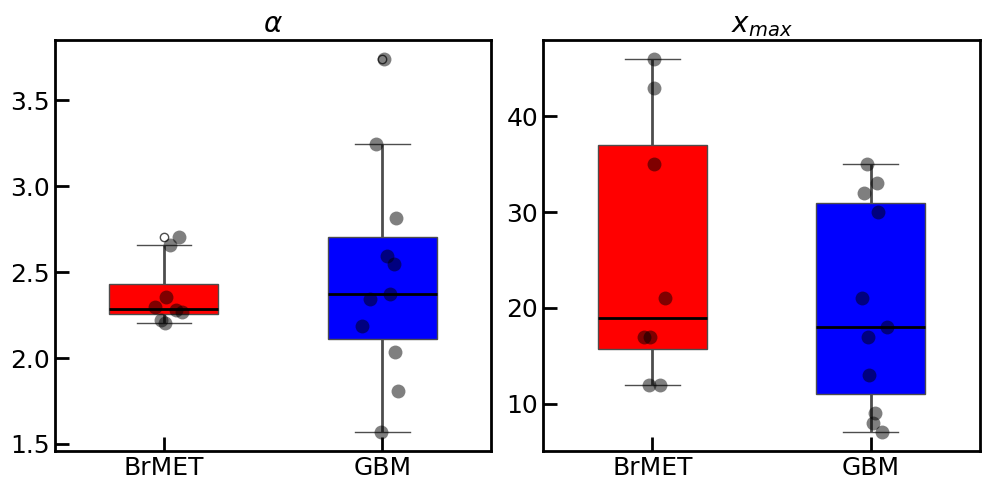

In [47]:
import seaborn as sns
exponents_df["GBM"] = exponents_df["Patient"].str.contains("GBM")
columns = ["alpha", "xmax"]
titles = [rf'$\alpha$', r'$x_{max}$']
colors = {False: 'red', True: 'blue'}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for i, (ax, col) in enumerate(zip(axes, columns)):
    sns.boxplot(
        x="GBM",
        y=col,
        data=exponents_df,
        hue="GBM",
        palette=colors,
        saturation=1,
        legend=False,
        width=0.5,
        ax=ax,
        medianprops={"color": "black", "linewidth": 2},
        whiskerprops={"linewidth": 2},
    )
    sns.stripplot(
        x="GBM",
        y=col,
        data=exponents_df,
        color='black',  # Color of the points
        alpha=0.5,      # Transparency of the points
        ax=ax,
        size=10          # Size of the points
    )
    # # Assuming you have a column 'error' in your DataFrame for individual errors
    # for index, row in exponents_df.iterrows():
    #     ax.errorbar(
    #         x=1 if row['GBM'] else 0,  # Use 1 for GBM and 0 for BrMET
    #         y=row[col],
    #         yerr=row['sigma'],  # Replace 'error' with the actual column name for errors
    #         fmt='o',
    #         color='black',
    #         capsize=5,
    #         alpha=0.5
    #     )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["BrMET", "GBM"])
    ax.set_title(titles[i], fontsize=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    xtick_labels, ytick_labels = ax.get_xticklabels(), ax.get_yticklabels()
    for label in xtick_labels + ytick_labels:
        label.set_fontsize(24)
    ax.tick_params(
        axis="x", which="major", direction="in", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="x", which="minor", direction="in", length=5, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="major", direction="in", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="minor", direction="in", length=5, width=2, labelsize=18
    )
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.yaxis.labelpad = 20
    ax.xaxis.labelpad = 20
plt.tight_layout()
plt.show()

In [55]:
row['Patient']

'BrMET008'

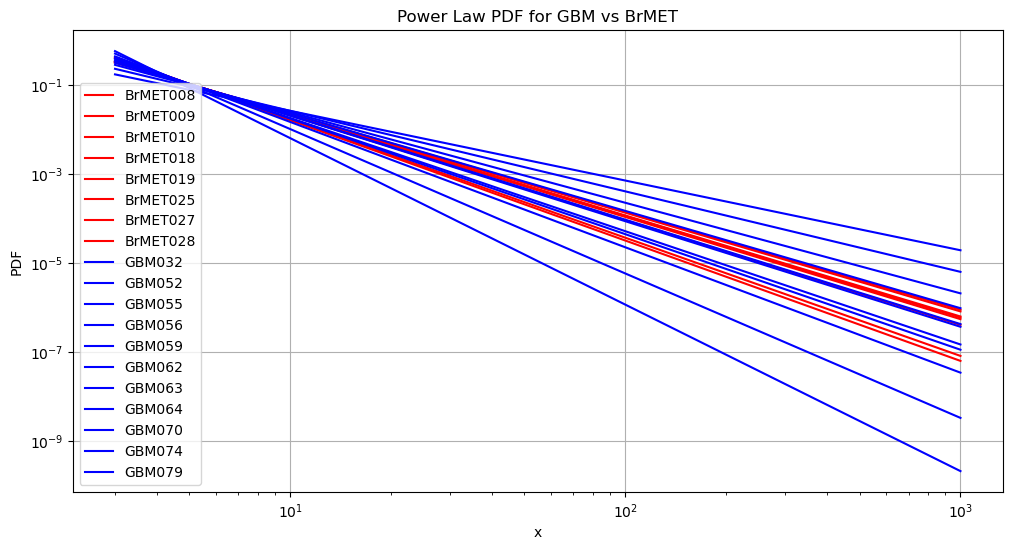

In [61]:
# Create a range of x values from 3 to 1000
x_values = np.linspace(3, 1000, 1000)

# Define colors and markers for each group
colors = {'BrMET': 'red', 'GBM': 'blue'}

# Plot the power law PDF for each alpha in exponents_df
plt.figure(figsize=(12, 6))
for index, row in exponents_df.iterrows():
    alpha = row['alpha']
    y_values = power_law_pdf(x_values, alpha)
    group = 'GBM' if 'GBM' in row['Patient'] else 'BrMET'  # Determine group based on Patient ID
    plt.plot(x_values, y_values, label=row['Patient'], color=colors[group], linestyle='-', markersize=5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Power Law PDF for GBM vs BrMET')
plt.legend()
plt.grid()
plt.show()

In [62]:
exponents_df

,Patient,alpha,xmin,xmax,XMAX,n,N,GBM
0,BrMET008,2.353112,3,17,133,14,21,False
1,BrMET009,2.201779,3,43,6314,41,163,False
2,BrMET010,2.656231,3,21,837,19,58,False
3,BrMET018,2.296292,3,35,696,33,83,False
4,BrMET019,2.219059,3,17,358,15,53,False
5,BrMET025,2.704181,3,12,384,10,35,False
6,BrMET027,2.269847,3,46,476,41,79,False
7,BrMET028,2.280026,3,12,32,10,18,False
8,GBM032,2.345271,3,33,191,30,72,True
9,GBM052,2.371814,3,35,1178,31,69,True


In [65]:
from scipy.stats import f, levene, bartlett, ttest_ind
######## TEST OF EQUAL VARIANCEs ########
########## F-TEST #################
group1, group2 = exponents_df[exponents_df["GBM"]==False]['alpha'], exponents_df[exponents_df["GBM"]==True]['alpha']
var1 = np.var(group1, ddof=1)
var2 = np.var(group2, ddof=1)
# Calculate F-statistic
F = var1 / var2
# Degrees of freedom
n1 = len(group1)
n2 = len(group2)
df1 = n1 - 1
df2 = n2 - 1
# Calculate p-value
p_value = 1 - f.cdf(F, df1, df2)
# Output results
print(f"F-statistic: {F}, p-value: {p_value}")

########## LEVENE'S-TEST #################
stat, p_value = levene(group1, group2)
print(f"Levene's test statistic: {stat}, p-value: {p_value}")

########## BARTLETT's-TEST #################
stat, p_value = bartlett(group1, group2)
print(f"Bartlett's test statistic: {stat}, p-value: {p_value}")



############ STANDARD T-TEST ################
mean1 = np.mean(group1)
mean2 = np.mean(group2)
std1 = np.std(group1, ddof=1)
std2 = np.std(group2, ddof=1)
t_stat, p_value = ttest_ind(group1, group2, equal_var=False)  # Use equal_var=False for Welch's t-test
print(f"Mean of Group 1: {mean1}, Standard Deviation: {std1}")
print(f"Mean of Group 2: {mean2}, Standard Deviation: {std2}")
print(f"Welch's t-statistic: {t_stat}, p-value: {p_value}")

F-statistic: 0.09819504016650508, p-value: 0.9972351106536717
Levene's test statistic: 4.270064210427409, p-value: 0.05437266133316472
Bartlett's test statistic: 7.872116689195792, p-value: 0.0050202853881854016
Mean of Group 1: 2.372565877636143, Standard Deviation: 0.1958415922691912
Mean of Group 2: 2.4781593000490383, Standard Deviation: 0.6249714170269539
Welch's t-statistic: -0.5259829231461732, p-value: 0.6080656745999704


# FIT BY REGIONS:

import warnings
warnings.filterwarnings('ignore')

a = ['combined', 'region1', 'region2', 'region3', 'region4']
result_df = pd.DataFrame(np.transpose(np.array([np.concatenate([[pid]*len(a) for pid in patients]), a*len(patients)])), columns=['Patient', 'Region'])
result_df['alpha'] = None
result_df['xmin'] = None
result_df['xmax'] = None
result_df['XMAX'] = None
result_df['n'] = None
result_df['N'] = None

for patient_id in patients[:]:
    data_dir = f"{root_dir}/data/glioblastoma_data/"
    filepaths = os.path.join(data_dir, patient_id, f"{patient_id}_region*.csv")
    files = glob.glob(filepaths)
    sorted_files = sorted(files, key=lambda x: int(x.split("region")[1].split(".")[0]))
    region_labels = [f'region{file.split("region")[1].split("_")[0][:-4]}' for file in sorted_files]
    data = []
    
    for file in sorted_files:
        df = pd.read_csv(file, sep=",",)
        data.append(df)
    
    #Add combined data at the end of each list wherever necessary
    combined_data = full_data[full_data['Patient']==patient_id]
    data = [combined_data] + data
    region_labels =  ['combined'] + region_labels
    
    xmin = 3
    fig, axes = plt.subplots(
        nrows=1, 
        ncols=len(data),
        figsize=(15, 5),
    )
    # Convert axes to array if there's only one subplot
    if len(data) == 1:
        axes = [axes]
    
    for i, (regional_data, ax, label) in enumerate(zip(data, axes, region_labels)):
        if len(regional_data)==0:
            continue
        x_data, y_data = pdf(regional_data['counts'].values)
        ax.scatter(x_data, y_data, s=100, facecolors="white", edgecolors="black", label='data', zorder=1, alpha=1)
        
        # Find the index of the first occurrence of min(y_data)
        min_index = np.argmin(y_data)
        xmax_start = x_data[min_index]
        best_xmax = None
        best_fit_x_data = None
        best_fit_y_data = None
        min_noise = np.inf
        best_alpha = None
        for xmax in tqdm.tqdm(range(xmax_start, max(x_data)+1), leave=False):
            fit_patient_data = regional_data[(regional_data['counts']>=xmin) & (regional_data['counts']<=xmax)]
            fit_data = pdf(fit_patient_data["counts"].values)
            fit_x_data, fit_y_data = fit_data[0], fit_data[1]
            if len(fit_x_data)>5:
                optimal_alpha, _ = curve_fit(power_law_pdf, fit_x_data, fit_y_data)
                y_pred = power_law_pdf(fit_x_data, optimal_alpha[0])
                avgRSS =  (np.sum((np.log(y_pred) - np.log(fit_y_data)) ** 2)) / len(fit_x_data)
                if avgRSS < min_noise:
                    min_noise = avgRSS
                    best_xmax = xmax
                    best_fit_x_data = fit_x_data
                    best_fit_y_data = fit_y_data
                    best_alpha = optimal_alpha[0]
        # Update result_df
        result_df.loc[(result_df['Patient'] == patient_id) & (result_df['Region'] == label), 'alpha'] = best_alpha
        result_df.loc[(result_df['Patient'] == patient_id) & (result_df['Region'] == label), 'xmin'] = xmin
        result_df.loc[(result_df['Patient'] == patient_id) & (result_df['Region'] == label), 'xmax'] = best_xmax
        result_df.loc[(result_df['Patient'] == patient_id) & (result_df['Region'] == label), 'XMAX'] = max(x_data)
        result_df.loc[(result_df['Patient'] == patient_id) & (result_df['Region'] == label), 'n'] = None if best_alpha is None else len(best_fit_x_data)
        result_df.loc[(result_df['Patient'] == patient_id) & (result_df['Region'] == label), 'N'] = len(x_data)
        
        # Plot best fit if found
        if best_alpha is not None:
            ax.scatter(best_fit_x_data, best_fit_y_data, s=100, facecolors="green", 
                       edgecolors="black", label="data for fit", zorder=1, alpha=1)
            ax.plot(best_fit_x_data, power_law_pdf(best_fit_x_data, best_alpha), 
                   linewidth=1.5, color='black', label=r'best model fit')
    
        ax.set_xscale("log")
        ax.set_yscale("log")
        # ax.vlines(x=best_xmax, ymin=min(ax.get_yticks()), ymax=max(ax.get_yticks()), linestyles="dashed", colors="gray")
        # ax.text(1.2*best_xmax, np.log10((max(ax.get_yticks())+min(ax.get_yticks()))/2), f'x={best_xmax}', horizontalalignment='center', fontsize=12, color='black')
        ax.set_xlabel(r"Clone Sizes ($x$)", fontsize=18)
        ax.set_ylabel("PDF", fontsize=18)
        ax.set_title(f"{patient_id}-{label}", fontsize=12)
        # ax.tick_params(axis='both', which='major', labelsize=20)
    plt.tight_layout()
    plt.show()

In [1]:
import pandas as pd
excel_file = '/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx'
exponents_df = pd.read_excel(excel_file, sheet_name='exponents')
exponents_df

,Patient,Region,alpha,xmin,xmax,XMAX,n,N
0,BrMET008,combined,2.353112,3.0,17.0,133.0,14.0,21.0
1,BrMET008,region1,2.415642,3.0,10.0,116.0,8.0,16.0
2,BrMET008,region2,1.561962,3.0,8.0,8.0,6.0,8.0
3,BrMET008,region3,NaN,3.0,NaN,3.0,NaN,3.0
4,BrMET008,region4,NaN,3.0,NaN,10.0,NaN,7.0
...,...,...,...,...,...,...,...,...
90,GBM079,combined,2.816940,3.0,13.0,242.0,11.0,27.0
91,GBM079,region1,1.214393,3.0,8.0,8.0,6.0,8.0
92,GBM079,region2,2.941440,3.0,9.0,235.0,7.0,20.0
93,GBM079,region3,1.733365,3.0,11.0,89.0,6.0,9.0


In [7]:
from scipy.stats import f, levene, bartlett, ttest_ind
######## TEST OF EQUAL VARIANCEs ########
########## F-TEST #################
req_df = exponents_df[(exponents_df['Region']=='combined') & (exponents_df['alpha'].notna())]
group1, group2 = req_df[req_df["GBM"]==False]['alpha'], req_df[req_df["GBM"]==True]['alpha']
var1 = np.var(group1, ddof=1)
var2 = np.var(group2, ddof=1)
# Calculate F-statistic
F = var1 / var2
# Degrees of freedom
n1 = len(group1)
n2 = len(group2)
df1 = n1 - 1
df2 = n2 - 1
# Calculate p-value
p_value = 1 - f.cdf(F, df1, df2)
# Output results
print(f"F-statistic: {F}, p-value: {p_value}")

########## LEVENE'S-TEST #################
stat, p_value = levene(group1, group2)
print(f"Levene's test statistic: {stat}, p-value: {p_value}")

########## BARTLETT's-TEST #################
stat, p_value = bartlett(group1, group2)
print(f"Bartlett's test statistic: {stat}, p-value: {p_value}")

############ STANDARD T-TEST ################
mean1 = np.mean(group1)
mean2 = np.mean(group2)
std1 = np.std(group1, ddof=1)
std2 = np.std(group2, ddof=1)
t_stat, p_value = ttest_ind(group1, group2, equal_var=False)  # Use equal_var=False for Welch's t-test
print(f"Mean of Group 1: {mean1}, Standard Deviation: {std1}")
print(f"Mean of Group 2: {mean2}, Standard Deviation: {std2}")
print(f"Welch's t-statistic: {t_stat}, p-value: {p_value}")

F-statistic: 0.08573265356478368, p-value: 0.9981858907530172
Levene's test statistic: 4.366047425587083, p-value: 0.05200430974157408
Bartlett's test statistic: 8.635977834406129, p-value: 0.0032958828629074542
Mean of Group 1: 2.3725658776361427, Standard Deviation: 0.19584159226919115
Mean of Group 2: 2.453249337031247, Standard Deviation: 0.6688547235045978
Welch's t-statistic: -0.3783998851260959, p-value: 0.7116080066190285


In [8]:
from scipy.stats import f, levene, bartlett, ttest_ind
######## TEST OF EQUAL VARIANCEs ########
########## F-TEST #################
req_df = exponents_df[(exponents_df['Region']!='combined') & (exponents_df['alpha'].notna())]
group1, group2 = req_df[req_df["GBM"]==False]['alpha'], req_df[req_df["GBM"]==True]['alpha']
var1 = np.var(group1, ddof=1)
var2 = np.var(group2, ddof=1)
# Calculate F-statistic
F = var1 / var2
# Degrees of freedom
n1 = len(group1)
n2 = len(group2)
df1 = n1 - 1
df2 = n2 - 1
# Calculate p-value
p_value = 1 - f.cdf(F, df1, df2)
# Output results
print(f"F-statistic: {F}, p-value: {p_value}")

########## LEVENE'S-TEST #################
stat, p_value = levene(group1, group2)
print(f"Levene's test statistic: {stat}, p-value: {p_value}")

########## BARTLETT's-TEST #################
stat, p_value = bartlett(group1, group2)
print(f"Bartlett's test statistic: {stat}, p-value: {p_value}")



############ STANDARD T-TEST ################
mean1 = np.mean(group1)
mean2 = np.mean(group2)
std1 = np.std(group1, ddof=1)
std2 = np.std(group2, ddof=1)
t_stat, p_value = ttest_ind(group1, group2, equal_var=False)  # Use equal_var=False for Welch's t-test
print(f"Mean of Group 1: {mean1}, Standard Deviation: {std1}")
print(f"Mean of Group 2: {mean2}, Standard Deviation: {std2}")
print(f"Welch's t-statistic: {t_stat}, p-value: {p_value}")

F-statistic: 0.6541700705891411, p-value: 0.833229521463284
Levene's test statistic: 1.0863050558573344, p-value: 0.30273826896768147
Bartlett's test statistic: 0.9707650435595874, p-value: 0.32448945334850465
Mean of Group 1: 2.4047180145282816, Standard Deviation: 0.6199374358715773
Mean of Group 2: 2.455508368023561, Standard Deviation: 0.7664830007748041
Welch's t-statistic: -0.2537609285638553, p-value: 0.8008133192047135


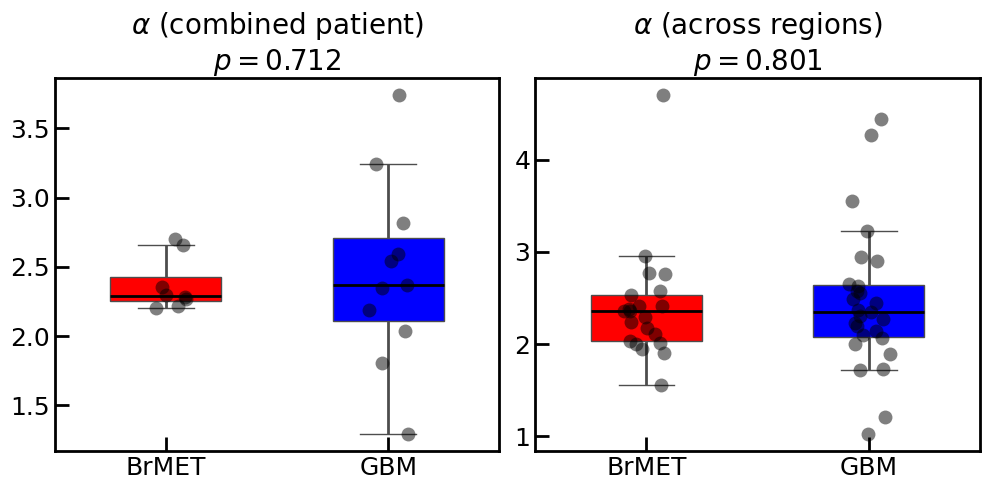

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
exponents_df["GBM"] = exponents_df["Patient"].str.contains("GBM")
# p_values = [0.7116080066190285, 0.8008133192047135]
titles = [rf'$\alpha$ (combined patient)', r'$\alpha$ (across regions)']
colors = {False: 'red', True: 'blue'}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1, ax2 = axes
sns.boxplot(
        x="GBM",
        y='alpha',
        data=exponents_df[exponents_df['Region']=='combined'],
        hue="GBM",
        palette=colors,
        saturation=1,
        legend=False,
        width=0.5,
        ax=ax1,
        medianprops={"color": "black", "linewidth": 2},
        whiskerprops={"linewidth": 2},
        showfliers=False,
    )
sns.stripplot(
        x="GBM",
        y='alpha',
        data=exponents_df[exponents_df['Region']=='combined'],
        color='black',  # Color of the points
        alpha=0.5,      # Transparency of the points
        ax=ax1,
        size=10          # Size of the points
    )
sns.boxplot(
        x="GBM",
        y='alpha',
        data=exponents_df[exponents_df['Region']!='combined'],
        hue="GBM",
        palette=colors,
        saturation=1,
        legend=False,
        width=0.5,
        ax=ax2,
        medianprops={"color": "black", "linewidth": 2},
        whiskerprops={"linewidth": 2},
        showfliers=False,
    )
sns.stripplot(
        x="GBM",
        y='alpha',
        data=exponents_df[exponents_df['Region']!='combined'],
        color='black',  # Color of the points
        alpha=0.5,      # Transparency of the points
        ax=ax2,
        size=10          # Size of the points
    )
for i in range(2):
    ax = [ax1, ax2][i]
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["BrMET", "GBM"])
    ax.set_title(titles[i] + '\n' + f'$p={p_values[i]:.3f}$', fontsize=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    xtick_labels, ytick_labels = ax.get_xticklabels(), ax.get_yticklabels()
    for label in xtick_labels + ytick_labels:
        label.set_fontsize(24)
    ax.tick_params(
        axis="x", which="major", direction="in", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="x", which="minor", direction="in", length=5, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="major", direction="in", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="minor", direction="in", length=5, width=2, labelsize=18
    )
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.yaxis.labelpad = 20
    ax.xaxis.labelpad = 20
plt.tight_layout()
plt.show()

# Plots after all of the above work is done

In [ ]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data.csv', sep=',')
full_data

In [ ]:
excel_file = '/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx'
exponents_df = pd.read_excel(excel_file, sheet_name='exponents')
exponents_df

In [ ]:
import warnings
warnings.filterwarnings('ignore')

a = ['combined', 'region1', 'region2', 'region3', 'region4']

patients = exponents_df['Patient'].unique()
for patient_id in patients[:]:
    data = {}
    combined_data = full_data[full_data['Patient']==patient_id]
    data['combined'] = combined_data
    
    data_dir = f"{root_dir}/data/glioblastoma_data/"
    filepaths = os.path.join(data_dir, patient_id, f"{patient_id}_region*.csv")
    files = glob.glob(filepaths)
    sorted_files = sorted(files, key=lambda x: int(x.split("region")[1].split(".")[0]))
    region_labels = [f'region{file.split("region")[1].split("_")[0][:-4]}' for file in sorted_files]
    for label, file in zip(region_labels, sorted_files):
        df = pd.read_csv(file, sep=",",)
        data[label] = df
    region_labels =  ['combined'] + region_labels
    
    xmin_dict = {}
    xmax_dict = {}
    alpha_dict = {}
    for region in data.keys():
        patient_exponent_df = exponents_df[(exponents_df['Patient']==patient_id) & (exponents_df['Region']==region)]
        xmin_dict[region] = patient_exponent_df['xmin'].values[0]
        xmax_dict[region] = patient_exponent_df['xmax'].values[0]
        alpha_dict[region] = patient_exponent_df['alpha'].values[0]
    
    non_nan_regions = [key for key, value in alpha_dict.items() if not np.isnan(value)]
    # print(patient_id, non_nan_regions)
    nrows=1
    ncols = len(non_nan_regions)
    fig, axes = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=(15, 5),
    )
    # Convert axes to array if there's only one subplot
    if ncols == 1:
        axes = [axes]
    
    for ax, region in zip(axes, non_nan_regions):
        xmin = xmin_dict[region]
        xmax = xmax_dict[region]
        alpha = alpha_dict[region]
        x_data, y_data = pdf(data[region]['counts'].values)
        ax.scatter(x_data, y_data, s=50, facecolors="white", edgecolors="black", label='data', zorder=1, alpha=1)
        mask = (x_data>=xmin) & (x_data<=xmax)
        fitted_x_data = x_data[mask]
        fitted_y_data = y_data[mask]
        ax.scatter(fitted_x_data, fitted_y_data, s=50, facecolors="green", edgecolors="black", label="fitted", zorder=1, alpha=0.5)
        amplitude = y_data[x_data == xmin]
        predicted_y_data = amplitude * (fitted_x_data/xmin)**(-alpha)
        ax.plot(fitted_x_data, predicted_y_data, linewidth=1.5, color='black', label=r'best fit')
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel(r"Clone Sizes ($x$)", fontsize=18)
        ax.set_ylabel("PDF", fontsize=18)
        ax.set_title(f"{patient_id}-{region}", fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.legend(loc='best', fontsize=14)
    plt.tight_layout()
    plt.show()